In [82]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [83]:
Test='mnist_png\\mnist_png\\testing'
Train='mnist_png\\mnist_png\\training'
Digits=['0','1','2','3','4','5','6','7','8','9']
Test_Path=os.path.join(os.getcwd(),Test)
Training_Path=os.path.join(os.getcwd(),Train)
Path=os.path.join(Test_Path,'2')
print(Path)
for i in os.listdir(Path):
    display(Image(filename=os.path.join(Path,i)))
    break

C:\Users\Dwijraj\Hand Written MNIST\mnist_png\mnist_png\testing\2


In [84]:
Pickle_Files=[]
for i in Digits:
    Pickle_Files.append(i+'.pickle')

In [85]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, Max_images):
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
      if num_images==Max_images:
        return dataset
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

for i in os.listdir(Training_Path):
     set_filename=i+'.pickle'
     if set_filename in os.listdir(os.getcwd()):
        print(i+' is Already Pickled ')
     else:
        
         dataset=load_letter(os.path.join(Training_Path,i), 5000)
         set_filename=i+'.pickle'
         try:
            with open(set_filename, 'wb') as f:
              pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
         except Exception as e:
            print('Unable to save data to', set_filename, ':', e)

0 is Already Pickled 
1 is Already Pickled 
2 is Already Pickled 
3 is Already Pickled 
4 is Already Pickled 
5 is Already Pickled 
6 is Already Pickled 
7 is Already Pickled 
8 is Already Pickled 
9 is Already Pickled 


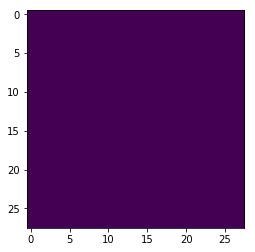

In [86]:
pickle_file = Pickle_Files[0]  
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  
    sample_idx = np.random.randint(len(letter_set))  
    sample_image = letter_set[sample_idx, :, :]  
    plt.figure()
    plt.imshow(sample_image)  

In [87]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray((nb_rows,), dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):
    print(label,":",pickle_file)    
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 40000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  Pickle_Files, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(Pickle_Files, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

0 : 0.pickle
1 : 1.pickle
2 : 2.pickle
3 : 3.pickle
4 : 4.pickle
5 : 5.pickle
6 : 6.pickle
7 : 7.pickle
8 : 8.pickle
9 : 9.pickle
0 : 0.pickle
1 : 1.pickle
2 : 2.pickle
3 : 3.pickle
4 : 4.pickle
5 : 5.pickle
6 : 6.pickle
7 : 7.pickle
8 : 8.pickle
9 : 9.pickle
Training: (40000, 28, 28) (40000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [88]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [89]:
pickle_file = os.path.join(os.getcwd(), 'Data.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [90]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 188400502


In [93]:
import time as t
clf='LogisticRegressionCLassifier.pickle'
if clf in os.listdir(os.getcwd()):
    print('Classifier Already Present')
    f=open('LogisticRegressionCLassifier.pickle','rb')
    Clf=pickle.load(f)
    print(Clf)
else:    
    clf = LogisticRegressionCV()
    train_dataset=train_dataset.reshape((train_dataset.shape[0],train_dataset.shape[1]*train_dataset.shape[2]))
    print(train_dataset.shape)
    print(train_labels.shape)
    A=t.time()
    print('Training start time',t.time())
    clf.fit(train_dataset,train_labels)
    print('Training End Time time',t.time())
    print('Time taken',t.time()-A)
    A=t.time()
    print('Prediction start time',t.time())
    print('Train_Accuracy',accuracy_score(train_labels,clf.predict(train_dataset)))
    print('Prediction time taken',t.time()-A)
    f=open('LogisticRegressionCLassifier.pickle','wb')
    pickle.dump(clf,f,pickle.HIGHEST_PROTOCOL)
    f.close()

Classifier Already Present
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)
